In [1]:
import pandas as pd

import hilbert
import numpy as np

from tqdm import trange, tqdm

import scipy.spatial as spatial

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [7]:
res_df = pd.read_csv('results/Japan_octect_3_time_100k_final.csv')
res_df_coords = hilbert.decode(res_df.integer.to_numpy(), num_bits=12, num_dims=2)
res_df['x'] = res_df_coords[:, 0]
res_df['y'] = res_df_coords[:, 1]
res_df['color'] = -1

In [9]:
orig_df = pd.read_csv('data/Japan_dataset_octet_3.csv')
orig_df_coords = hilbert.decode(orig_df[orig_df.label == 1].integer.to_numpy(), num_bits=12, num_dims=2)

In [14]:
threshold = res_df[res_df.lbf_label == 0].time.median()
threshold #time threshold

92625.0

In [15]:
emperical_ft = res_df[(res_df.lbf_label != 0) & (res_df.time <= threshold)]
fts_indices = np.column_stack((emperical_ft['x'].to_numpy(), emperical_ft['y'].to_numpy()))

In [18]:
point_tree = spatial.cKDTree(fts_indices)
grid = np.zeros(fts_indices.shape[0])

color = 1
thresh = 100
for i in range(len(fts_indices)):
    if grid[i] != 0:
        continue
    nearest_indices = point_tree.query_ball_point(fts_indices[i], thresh)
    for j in nearest_indices:
        grid[j] = color
    color += 1

In [20]:
for i in range(len(grid)):
    x, y = fts_indices[i]
    index = res_df.index[(res_df.x == x) & (res_df.y == y)]
    assert len(index) >= 1, (x, y)

    for j in index:
        res_df.at[j, 'color'] = grid[i]


In [21]:
## CREATE CONVEX HULL

In [22]:
hull_colors = res_df[res_df.color != -1]['color'].unique()

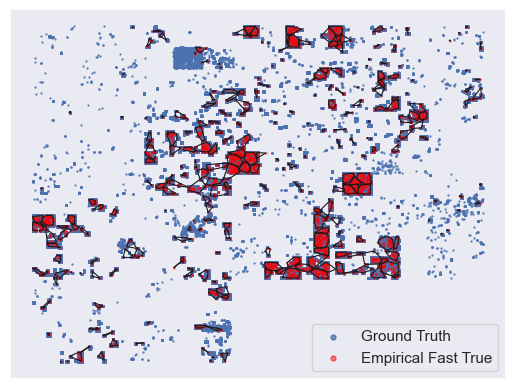

In [30]:
fig, ax = plt.subplots()

ax.scatter(orig_df_coords[:, 0], orig_df_coords[:, 1], label="Ground Truth", s=0.5, alpha=0.8)

ax.scatter(res_df[res_df.color != -1]['x'], res_df[res_df.color != -1]['y'], color="red", s=0.5, label="Empirical Fast True", alpha=0.5)

for c in hull_colors:
    hull_points = res_df[['x', 'y']][res_df.color == c].to_numpy()
    if len(hull_points) <= 2:
        for point in hull_points:
            cir = plt.Circle(point, 5, color='k',fill=False, linewidth=0.8)
            ax.add_patch(cir)
    else:    
        hull = spatial.ConvexHull(hull_points)
    
        for simplex in hull.simplices:
            ax.plot(hull_points[simplex, 0], hull_points[simplex, 1], 'k-', linewidth=0.8)

ax.legend(markerscale=5)
plt.xticks([])
plt.yticks([])
plt.show()